**Yuval Israel Adir and Uri Amiel shared CoLab.**

In this notebook we have trained models in order to solve a problem of offensive language detection as part of Natural Lanuguage Proccessing class in Reichman University.

# Initiallization


In [ ]:
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import spacy
import re
import os

import logging
from gensim.models import FastText
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score

import keras
from keras.models import Model
from keras.layers import Dropout, Conv1D, MaxPooling1D, LSTM,Concatenate, Dense, GlobalMaxPooling1D,GlobalAveragePooling1D, Lambda, Input, Bidirectional, GRU, concatenate, SpatialDropout1D, Reshape, merge
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences

In [ ]:
!pip install GPyOpt
import GPyOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Preprocess the data

In [ ]:
def read_csv_file(file_name):
  return pd.read_csv(file_name, sep = "\t", header = 0)

In [ ]:
test_data_a = read_csv_file("testset-levela.tsv")
test_data_b = read_csv_file("testset-levelb.tsv")
test_data_c = read_csv_file("testset-levelc.tsv")

data = read_csv_file("olid-training-v1.0.tsv")

## Cleaning the data

In [ ]:
def sub_word(word):
    word = re.sub("[#@]", "", word)
    word = re.sub("!", " !", word)
    word = re.sub("[?]", " ?", word)
    return word

In [ ]:
def clean_data(phrase):
    splitted_phrase = phrase.lower().split()
    clean_phrases = []
    user_count = 0
    prev = None
    for word in splitted_phrase:
        word = sub_word(word)

        if (word == "user"):
            user_count += 1
            if (prev == "user"):
                pass
        else:    
            clean_phrases.append(word)
        prev = word
    return " ".join(clean_phrases), user_count

In [ ]:
data = data.merge(data.tweet.apply(lambda x:pd.Series({'clean':clean_data(x)[0], 'user_count': clean_data(x)[1]})), left_index=True, right_index=True)
max_user_count = data["user_count"].max()
data["user_count"] = data["user_count"].apply(lambda x: x / max_user_count)

In [ ]:
def get_datas():
    return data[data["subtask_a"].notna()],data[data["subtask_b"].notna()],data[data["subtask_c"].notna()] 

data_a , data_b , data_c = get_datas()

In [ ]:
def get_x_and_label(data, subtask):
    return data[["clean", "user_count"]], data[subtask]

X_a, label_a = get_x_and_label(data_a, "subtask_a")
X_b, label_b = get_x_and_label(data_b, "subtask_b")
X_c, label_c = get_x_and_label(data_c, "subtask_c")

In [ ]:
def get_labels():
    return {'OFF': 0, 'NOT': 1}, {'UNT': 0, 'TIN': 1}, {'IND': 0, 'OTH': 1, 'GRP': 2}

label_to_number_a, label_to_number_b, label_to_number_c = get_labels()


In [ ]:
def get_number_to_label(label_to_number):
    return {v:k for k, v in label_to_number.items()}

number_to_label_a = get_number_to_label(label_to_number_a)
number_to_label_b = get_number_to_label(label_to_number_b)
number_to_label_c = get_number_to_label(label_to_number_c)

In [ ]:
binary_labels_a = data_a.subtask_a.apply(lambda x:label_to_number_a[x])
binary_labels_b = data_b.subtask_b.apply(lambda x:label_to_number_b[x])
binary_labels_c = data_c.subtask_c.apply(lambda x:label_to_number_c[x])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.clean)
sequences = tokenizer.texts_to_sequences(data.clean)
seq = pad_sequences(sequences)

max_seq = len(seq[0])

In [ ]:
def build_seq(dataset):
  sequences = tokenizer.texts_to_sequences(dataset.clean)
  return pad_sequences(sequences, maxlen=max_seq)

In [ ]:
test_size = 0.2
X_train_a, X_test_a, count_train_a, count_test_a, y_train_a, y_test_a = train_test_split(build_seq(X_a), X_a.user_count, binary_labels_a, test_size=test_size)
X_train_b, X_test_b, count_train_b, count_test_b, y_train_b, y_test_b = train_test_split(build_seq(X_b), X_b.user_count, binary_labels_b, test_size=test_size)
X_train_c, X_test_c, count_train_c, count_test_c, y_train_c, y_test_c = train_test_split(build_seq(X_c), X_c.user_count, binary_labels_c, test_size=test_size)

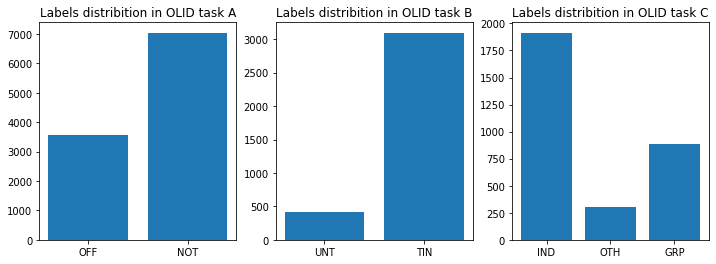

In [ ]:
plt.figure(figsize = (12,4))
plt.subplot(131)
y_train_a_counter = Counter(y_train_a)
plt.bar(list(y_train_a_counter.keys()), list(y_train_a_counter.values()))
plt.xticks(range(len(y_train_a_counter)), label_to_number_a)
plt.title("Labels distribition in OLID task A");
plt.subplot(132)
y_train_b_counter = Counter(y_train_b)
plt.bar(list(y_train_b_counter.keys()), list(y_train_b_counter.values()))
plt.xticks(range(len(y_train_b_counter)), label_to_number_b)
plt.title("Labels distribition in OLID task B");
plt.subplot(133)
y_train_c_counter = Counter(y_train_c)
plt.bar(list(y_train_c_counter.keys()), list(y_train_c_counter.values()))
plt.xticks(range(len(y_train_c_counter)), label_to_number_c)
plt.title("Labels distribition in OLID task C");

## Over or Under sampaling

The dataset is highly imbalanced, so we decide to combine oversampling and undersampling in order to have balanced dataset

In [ ]:
def same_size_data(X_train, count_train, y_train, ratio_down_over_up=0.5):
  X_train = list(X_train)
  count_train = list(count_train)
  y_train = list(y_train)
  
  n_cat = len(Counter(y_train))
  
  sorted_counter = Counter(y_train).most_common()
  max_cat = sorted_counter[0][1]
  min_cat = sorted_counter[-1][1]
  
  target = min_cat + (1-ratio_down_over_up)*(max_cat - min_cat)
  
  for i in range(n_cat):
    diff = int(sorted_counter[i][1] - target)
    k = 0
    if diff > 0:
      rm = 0    
      while rm <= diff:
        if(y_train[k] == sorted_counter[i][0]):
          X_train.pop(k)
          y_train.pop(k)
          count_train.pop(k)
          rm += 1
          k -=1
        k += 1
    else:
      ad = 0
      while ad <= -diff:
        if(y_train[k] == sorted_counter[i][0]):
          X_train.append(X_train[k])
          y_train.append(y_train[k])
          count_train.append(count_train[k])
          ad += 1
        k += 1
        
  return X_train, count_train, y_train

In [ ]:
X_train_a, count_train_a, y_train_a = same_size_data(X_train_a, count_train_a, y_train_a, 0.3)
X_train_a, count_train_a, y_train_a = shuffle(X_train_a, count_train_a, y_train_a)
X_train_b, count_train_b, y_train_b = same_size_data(X_train_b, count_train_b, y_train_b, 0.2)
X_train_b, count_train_b, y_train_b = shuffle(X_train_b, count_train_b, y_train_b)
X_train_c, count_train_c, y_train_c = same_size_data(X_train_c, count_train_c, y_train_c, 0.7)
X_train_c, count_train_c, y_train_c = shuffle(X_train_c, count_train_c, y_train_c)

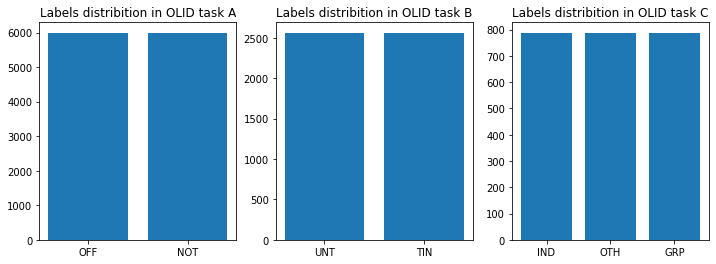

In [ ]:
plt.figure(figsize = (12,4))
plt.subplot(131)
cat_a = Counter(y_train_a)
plt.bar(list(cat_a.keys()), list(cat_a.values()))
plt.xticks(range(len(cat_a)), label_to_number_a)
plt.title("Labels distribition in OLID task A");
plt.subplot(132)
cat_b = Counter(y_train_b)
plt.bar(list(cat_b.keys()), list(cat_b.values()))
plt.xticks(range(len(cat_b)), label_to_number_b)
plt.title("Labels distribition in OLID task B");
plt.subplot(133)
cat_c = Counter(y_train_c)
plt.bar(list(cat_c.keys()), list(cat_c.values()))
plt.xticks(range(len(cat_c)), label_to_number_c)
plt.title("Labels distribition in OLID task C");

# Bag-of-Words

In order to determine the ration of undersampling and oversampling, we use a Random Forest Classier in different ratio and perform a cross-validation.

In [ ]:
TEST_SIZE = 0.2
RUNNING_RANGE = 9 # not recommended to change

In [ ]:
def get_bag_of_words_sum(count_test, label_test, rf, transformed_test):
    sum = 0
    for key, elem in classification_report(
            rf.predict(scipy.sparse.hstack([transformed_test, scipy.sparse.coo_matrix(np.array(count_test)[:, None])])),
            label_test, output_dict=True).items():
        classification_report_result = classification_report(
            rf.predict(scipy.sparse.hstack([transformed_test, scipy.sparse.coo_matrix(np.array(count_test)[:, None])])),
            label_test, output_dict=True)[key]
        if key != 'accuracy':
            sum += classification_report_result["f1-score"]
    return sum

In [ ]:
def seq_to_text(x):
  return tokenizer.sequences_to_texts(x)

In [ ]:
def get_transformed_data(tweets_train, tweets_test):
  v = CountVectorizer()
  return v.fit_transform(tweets_train), v.transform(tweets_test)

In [ ]:
def get_fit_classifier(transformed_train, counts_train, label_train):
  rf = RandomForestClassifier()
  rf.fit(scipy.sparse.hstack([transformed_train,  scipy.sparse.coo_matrix(np.array(counts_train)[:, None])]), label_train)
  return rf

In [ ]:
def tune_sampling(tweets_train, counts_train, label_train, tweets_test, count_test, label_test, should_print=False):
  tweets_train = seq_to_text(tweets_train)
  tweets_test = seq_to_text(tweets_test)

  transformed_train, transformed_test = get_transformed_data(tweets_train, tweets_test)
  rf = get_fit_classifier(transformed_train, counts_train, label_train)

  if (should_print):
    print(classification_report(rf.predict(scipy.sparse.hstack([transformed_test,  scipy.sparse.coo_matrix(np.array(count_test)[:, None])])), label_test))
  else:
    return get_bag_of_words_sum(count_test, label_test, rf, transformed_test)


In [ ]:
a_score = 0
b_score = 0
c_score = 0

best_a_ratio = 0.1
best_b_ratio = 0.1
best_c_ratio = 0.1

In [ ]:
for i in range(RUNNING_RANGE):
  
  temp_ratio = 0.1+i*0.1

  X_train_a, X_test_a, count_train_a, count_test_a, y_train_a, y_test_a = train_test_split(build_seq(X_a), X_a.user_count, binary_labels_a, test_size=TEST_SIZE)
  X_train_b, X_test_b, count_train_b, count_test_b, y_train_b, y_test_b = train_test_split(build_seq(X_b), X_b.user_count, binary_labels_b, test_size=TEST_SIZE)
  X_train_c, X_test_c, count_train_c, count_test_c, y_train_c, y_test_c = train_test_split(build_seq(X_c), X_c.user_count, binary_labels_c, test_size=TEST_SIZE)

  X_train_a, count_train_a, y_train_a = same_size_data(X_train_a, count_train_a, y_train_a, temp_ratio)
  X_train_a, count_train_a, y_train_a = shuffle(X_train_a, count_train_a, y_train_a)
  X_train_b, count_train_b, y_train_b = same_size_data(X_train_b, count_train_b, y_train_b, temp_ratio)
  X_train_b, count_train_b, y_train_b = shuffle(X_train_b, count_train_b, y_train_b)
  X_train_c, count_train_c, y_train_c = same_size_data(X_train_c, count_train_c, y_train_c, temp_ratio)
  X_train_c, count_train_c, y_train_c = shuffle(X_train_c, count_train_c, y_train_c)
  
  a_tune = tune_sampling(X_train_a, count_train_a, y_train_a, X_test_a, count_test_a, y_test_a)
  b_tune = tune_sampling(X_train_b, count_train_b, y_train_b, X_test_b, count_test_b, y_test_b)
  c_tune = tune_sampling(X_train_c, count_train_c, y_train_c, X_test_c, count_test_c, y_test_c)
  
  if(a_tune > a_score):
    best_a_ratio = temp_ratio
    a_score = a_tune
  if(b_tune > b_score):
    best_b_ratio = temp_ratio
    b_score = b_tune
  if(c_tune > c_score):
    best_c_ratio = temp_ratio
    c_score = c_tune

In [ ]:
tune_sampling(X_train_a, count_train_a ,y_train_a, X_test_a, count_test_a ,y_test_a,True)
tune_sampling(X_train_b,count_train_b ,y_train_b, X_test_b,count_test_b ,y_test_b,True)
tune_sampling(X_train_c,count_train_c ,y_train_c, X_test_c,count_test_c ,y_test_c,True)

              precision    recall  f1-score   support

           0       0.61      0.64      0.63       837
           1       0.83      0.82      0.82      1811

    accuracy                           0.76      2648
   macro avg       0.72      0.73      0.72      2648
weighted avg       0.76      0.76      0.76      2648

              precision    recall  f1-score   support

           0       0.47      0.24      0.32       209
           1       0.79      0.92      0.85       671

    accuracy                           0.76       880
   macro avg       0.63      0.58      0.58       880
weighted avg       0.72      0.76      0.72       880

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       457
           1       0.19      0.24      0.21        59
           2       0.69      0.58      0.63       260

    accuracy                           0.70       776
   macro avg       0.56      0.55      0.55       776
weighted avg       0

# Train embeddings

In [ ]:
EMBEDDING_SIZE = 100
WINDOW = 5
WORKERS = 4
ITER = 40
EPOCHS = 11

In [ ]:
def get_preprocessed_data(data):
  sequences = tokenizer.texts_to_sequences(data.clean)
  seq = pad_sequences(sequences)
  return tokenizer.sequences_to_texts(seq)

In [ ]:
def get_sentences():
  preprocessed = get_preprocessed_data(data)
  return [t.split() for t in preprocessed]

In [ ]:
sentences = get_sentences()

In [ ]:
model = FastText(sentences, size=EMBEDDING_SIZE, window=WINDOW, min_count=1, workers=WORKERS, iter = ITER)

In [ ]:
vocabulary_size = len(tokenizer.word_index)

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, EMBEDDING_SIZE))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model.wv.word_vec(word) 
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        print("KeyError, with ", word)

# CNN

In [ ]:
TASK_A_EPOCHS = 10 
TASK_B_EPOCHS = 9 
TASK_C_EPOCHS = 6
BATCH_SIZE = 20

In [ ]:
# UNCHANGABLE, CONSTS
LOSS_FUNC = 'binary_crossentropy'
OPTIMIZER = 'adam'
METRICS_D = 'accuracy'
TASK_A_TARGET_NAMES = ['OFF', 'NOT']
TASK_B_TARGET_NAMES = ['UNT', 'TIN']
TASK_C_TARGET_NAMES = ['IND', 'OTH', 'GRP']

In [ ]:
def get_y_value_and_input(vocabulary_size, embedding_matrix, max_seq, inp):
  val = Embedding(vocabulary_size + 1, EMBEDDING_SIZE, weights = [embedding_matrix], input_length=max_seq, trainable = True)(inp)
  val = Dropout(0.5)(val)
  val = Conv1D(64, 4, activation='relu')(val)
  val = GlobalMaxPooling1D()(val)
  val = Dense(10, activation ='relu')(val)
  return val

In [ ]:
inp = Input(shape = (max_seq,))
val = get_y_value_and_input(vocabulary_size, embedding_matrix, max_seq, inp)

In [ ]:
first_classfication = Dense(1, activation ='sigmoid')(val)
second_classification = Dense(3, activation ='sigmoid')(val)

Task A

In [ ]:
model_conv_a = Model(inputs = inp, outputs = first_classfication)
model_conv_a.compile(loss = LOSS_FUNC, optimizer=OPTIMIZER, metrics=[METRICS_D] )
model_conv_a.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 62)]              0         
                                                                 
 embedding_10 (Embedding)    (None, 62, 100)           2125100   
                                                                 
 dropout_2 (Dropout)         (None, 62, 100)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 59, 64)            25664     
                                                                 
 global_max_pooling1d_10 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_24 (Dense)            (None, 10)                650       
                                                          

In [ ]:
model_conv_a.fit(np.array(X_train_a), np.array(y_train_a), validation_data=(X_test_a,y_test_a), epochs = TASK_A_EPOCHS)

Epoch 1/10
243/243 [==============================] - 26s 47ms/step - loss: 0.7359 - accuracy: 0.4992 - val_loss: 0.6872 - val_accuracy: 0.3614
Epoch 2/10
243/243 [==============================] - 11s 46ms/step - loss: 0.6933 - accuracy: 0.5196 - val_loss: 0.6889 - val_accuracy: 0.3784
Epoch 3/10
243/243 [==============================] - 11s 44ms/step - loss: 0.6893 - accuracy: 0.5299 - val_loss: 0.6778 - val_accuracy: 0.4373
Epoch 4/10
243/243 [==============================] - 10s 42ms/step - loss: 0.6859 - accuracy: 0.5485 - val_loss: 0.6833 - val_accuracy: 0.4275
Epoch 5/10
243/243 [==============================] - 10s 40ms/step - loss: 0.6811 - accuracy: 0.5547 - val_loss: 0.6631 - val_accuracy: 0.5121
Epoch 6/10
243/243 [==============================] - 11s 44ms/step - loss: 0.6740 - accuracy: 0.5751 - val_loss: 0.6457 - val_accuracy: 0.5650
Epoch 7/10
243/243 [==============================] - 9s 36ms/step - loss: 0.6636 - accuracy: 0.5908 - val_loss: 0.6622 - val_accuracy: 

In [ ]:
y_pred_a = model_conv_a.predict(X_test_a)
print(classification_report(y_test_a, y_pred_a>0.5, target_names= TASK_A_TARGET_NAMES))

              precision    recall  f1-score   support

         OFF       0.44      0.68      0.54       869
         NOT       0.79      0.58      0.67      1779

    accuracy                           0.61      2648
   macro avg       0.61      0.63      0.60      2648
weighted avg       0.67      0.61      0.62      2648



Task B

In [ ]:
model_conv_b = Model(inputs = inp, outputs = first_classfication)
model_conv_b.compile(loss=LOSS_FUNC, optimizer=OPTIMIZER, metrics=[METRICS_D] )
model_conv_b.fit(np.array(X_train_b), np.array(y_train_b), validation_data=(X_test_b,y_test_b), epochs = TASK_B_EPOCHS)

Epoch 1/9
43/43 [==============================] - 3s 46ms/step - loss: 0.7006 - accuracy: 0.4909 - val_loss: 0.8002 - val_accuracy: 0.2250
Epoch 2/9
43/43 [==============================] - 2s 40ms/step - loss: 0.6790 - accuracy: 0.5127 - val_loss: 0.7258 - val_accuracy: 0.4580
Epoch 3/9
43/43 [==============================] - 2s 37ms/step - loss: 0.6604 - accuracy: 0.5564 - val_loss: 0.6859 - val_accuracy: 0.5818
Epoch 4/9
43/43 [==============================] - 2s 47ms/step - loss: 0.6474 - accuracy: 0.5980 - val_loss: 0.6755 - val_accuracy: 0.6080
Epoch 5/9
43/43 [==============================] - 2s 45ms/step - loss: 0.6273 - accuracy: 0.6256 - val_loss: 0.6371 - val_accuracy: 0.6568
Epoch 6/9
43/43 [==============================] - 2s 40ms/step - loss: 0.6082 - accuracy: 0.6540 - val_loss: 0.6413 - val_accuracy: 0.6614
Epoch 7/9
43/43 [==============================] - 2s 51ms/step - loss: 0.5987 - accuracy: 0.6577 - val_loss: 0.6478 - val_accuracy: 0.6409
Epoch 8/9
43/43 [===

In [ ]:
y_pred_b = model_conv_b.predict(X_test_b)
print(classification_report(y_test_b, y_pred_b>0.5, target_names = TASK_B_TARGET_NAMES))

              precision    recall  f1-score   support

         UNT       0.20      0.54      0.29       106
         TIN       0.92      0.71      0.80       774

    accuracy                           0.69       880
   macro avg       0.56      0.62      0.55       880
weighted avg       0.83      0.69      0.74       880



In [ ]:
model_conv_c = Model(inputs = inp, outputs = second_classification)
model_conv_c.compile(loss=LOSS_FUNC, optimizer=OPTIMIZER, metrics=[METRICS_D] )
dummy_labels_train = keras.utils.np_utils.to_categorical(y_train_c)
dummy_labels_test = keras.utils.np_utils.to_categorical(y_test_c)
model_conv_c.fit(np.array(X_train_c), dummy_labels_train, validation_data=(X_test_c,dummy_labels_test), epochs = TASK_C_EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/6
73/73 [==============================] - 4s 40ms/step - loss: 0.6141 - accuracy: 0.4217 - val_loss: 0.5655 - val_accuracy: 0.3544
Epoch 2/6
73/73 [==============================] - 3s 45ms/step - loss: 0.6012 - accuracy: 0.4356 - val_loss: 0.5503 - val_accuracy: 0.3879
Epoch 3/6
73/73 [==============================] - 3s 40ms/step - loss: 0.5931 - accuracy: 0.4494 - val_loss: 0.5480 - val_accuracy: 0.4034
Epoch 4/6
73/73 [==============================] - 3s 38ms/step - loss: 0.5954 - accuracy: 0.4314 - val_loss: 0.5438 - val_accuracy: 0.4072
Epoch 5/6
73/73 [==============================] - 2s 34ms/step - loss: 0.5826 - accuracy: 0.4591 - val_loss: 0.5446 - val_accuracy: 0.4072
Epoch 6/6
73/73 [==============================] - 2s 33ms/step - loss: 0.5840 - accuracy: 0.4564 - val_loss: 0.5383 - val_accuracy: 0.4188


In [ ]:
y_pred_c = model_conv_c.predict(X_test_c)
y_pred_c = np.argmax(y_pred_c,axis=1)
print(classification_report(y_test_c, y_pred_c, target_names = TASK_C_TARGET_NAMES))

              precision    recall  f1-score   support

         IND       0.82      0.56      0.66       482
         OTH       0.13      0.76      0.22        74
         GRP       0.14      0.00      0.01       220

    accuracy                           0.42       776
   macro avg       0.36      0.44      0.30       776
weighted avg       0.56      0.42      0.44       776



# RNN - CNN + Bidirect LSTM

In [ ]:
TASK_A_EPOCHS = 7
TASK_A_TARGET_NAMES = ["OFF",'NOT']

TASK_B_EPOCHS = 3
TASK_B_TARGET_NAMES = ["UNT",'TIN']

TASK_C_LOSS_FUNC = "categorical_crossentropy"
TASK_C_EPOCHS = 2
TASK_C_TARGET_NAMES = ["IND",'OTH', "GRP"]

CLEAN_DATA = "clean data"
PREDICTIONS = "predictions"

In [ ]:
# UNCHANGABLE, CONSTS
LOSS_FUNC = "binary_crossentropy"
OPTIMIZER_A = Adam(lr=0.001)
OPTIMIZER_B = "adam"
METRICS_D = "accuracy"

In [ ]:
def get_core_val(vocabulary_size, embedding_matrix, trainable, inp):
  core_value = Embedding(vocabulary_size+1, EMBEDDING_SIZE, weights = [embedding_matrix], trainable = trainable)(inp)
  core_value = SpatialDropout1D(0.5)(core_value)
  core_value = Bidirectional(LSTM(128, return_sequences = True))(core_value)
  core_value = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(core_value)
  avg_pool = GlobalAveragePooling1D()(core_value)
  max_pool = GlobalMaxPooling1D()(core_value)
  core_value = concatenate([avg_pool, max_pool])
  core_value = Dense(10, activation = "relu")(core_value)
  return core_value

In [ ]:
def get_input_and_model_values(max_seq, vocabulary_size, embedding_matrix, trainable):
  inp = Input(shape = (max_seq,))
  core_value = get_core_val(vocabulary_size, embedding_matrix, trainable, inp)
  
  a = Dense(1, activation = "sigmoid")(core_value)
  c = Dense(3, activation = "softmax")(core_value)
  return inp, a, c

In [ ]:
inp, a, c = get_input_and_model_values(max_seq, vocabulary_size, embedding_matrix, True)

model_a = Model(inputs = inp, outputs = a)
model_b = Model(inputs = inp, outputs = a)
model_c = Model(inputs = inp, outputs = c)

Task A

In [ ]:
model_a.compile( loss = LOSS_FUNC, optimizer = OPTIMIZER_A, metrics = [METRICS_D])
model_a.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 62)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 62, 100)      2125100     ['input_5[0][0]']                
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 62, 100)     0           ['embedding_4[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 62, 256)     234496      ['spatial_dropout1d_2[0][0

In [ ]:
def get_prediction(model, datas):
  pred = model.predict(datas)
  return pred > 0.5

In [ ]:
validation_data_a = (X_test_a,y_test_a)

In [ ]:
model_a.fit(np.array(X_train_a), np.array(y_train_a), validation_data=validation_data_a, epochs = TASK_A_EPOCHS)

Epoch 1/7
243/243 [==============================] - 53s 199ms/step - loss: 0.6738 - accuracy: 0.5760 - val_loss: 0.6677 - val_accuracy: 0.5827
Epoch 2/7
243/243 [==============================] - 46s 190ms/step - loss: 0.6268 - accuracy: 0.6362 - val_loss: 0.5984 - val_accuracy: 0.6809
Epoch 3/7
243/243 [==============================] - 47s 193ms/step - loss: 0.5865 - accuracy: 0.6783 - val_loss: 0.5893 - val_accuracy: 0.6888
Epoch 4/7
243/243 [==============================] - 46s 188ms/step - loss: 0.5615 - accuracy: 0.6982 - val_loss: 0.5769 - val_accuracy: 0.7013
Epoch 5/7
243/243 [==============================] - 46s 188ms/step - loss: 0.5287 - accuracy: 0.7306 - val_loss: 0.5742 - val_accuracy: 0.7145
Epoch 6/7
243/243 [==============================] - 48s 198ms/step - loss: 0.4955 - accuracy: 0.7522 - val_loss: 0.4995 - val_accuracy: 0.7625
Epoch 7/7
243/243 [==============================] - 46s 189ms/step - loss: 0.4696 - accuracy: 0.7772 - val_loss: 0.5947 - val_accuracy:

In [ ]:
y_pred_a = get_prediction(model_a, X_test_a)
print(classification_report(y_test_a, y_pred_a, target_names = TASK_A_TARGET_NAMES))

              precision    recall  f1-score   support

         OFF       0.54      0.83      0.65       869
         NOT       0.89      0.65      0.75      1779

    accuracy                           0.71      2648
   macro avg       0.71      0.74      0.70      2648
weighted avg       0.77      0.71      0.72      2648



In [ ]:
test_data_a[CLEAN_DATA] = test_data_a.tweet.apply(lambda x: clean_data(x)[0])
sequences = tokenizer.texts_to_sequences(test_data_a[CLEAN_DATA])
seq_test_a = pad_sequences(sequences, maxlen = max_seq)

In [ ]:
def get_t_predictions(model, seq_data, number_to_label):
  predictions = model.predict(seq_data)
  predictions = predictions > 0.5
  predictions = [number_to_label[int(v[0])] for v in predictions]

In [ ]:
predictions = get_t_predictions(model_a, seq_test_a, number_to_label_a) 

In [ ]:
test_data_a[PREDICTIONS] = predictions
reuslts= test_data_a[["id", PREDICTIONS]]
reuslts.to_csv("reuslts_a.csv", index = False, header = False)

In [ ]:
model_b.compile(loss = LOSS_FUNC, optimizer = OPTIMIZER_B , metrics = [METRICS_D])
model_b.fit(np.array(X_train_b), np.array(y_train_b), validation_data=(X_test_b,y_test_b), epochs = TASK_B_EPOCHS)

Epoch 1/3
43/43 [==============================] - 15s 237ms/step - loss: 0.7125 - accuracy: 0.5790 - val_loss: 0.7634 - val_accuracy: 0.5591
Epoch 2/3
43/43 [==============================] - 9s 202ms/step - loss: 0.6551 - accuracy: 0.6133 - val_loss: 0.6989 - val_accuracy: 0.7057
Epoch 3/3
43/43 [==============================] - 9s 198ms/step - loss: 0.6372 - accuracy: 0.6431 - val_loss: 0.6488 - val_accuracy: 0.7420


In [ ]:
y_pred_b = get_prediction(model_b, X_test_b)
print(classification_report(y_test_b, y_pred_b, target_names= TASK_B_TARGET_NAMES))

              precision    recall  f1-score   support

         UNT       0.22      0.44      0.29       106
         TIN       0.91      0.78      0.84       774

    accuracy                           0.74       880
   macro avg       0.56      0.61      0.57       880
weighted avg       0.83      0.74      0.78       880



In [ ]:
test_data_b[CLEAN_DATA] = test_data_b.tweet.apply(lambda x: clean_data(x)[0])
sequences = tokenizer.texts_to_sequences(test_data_b[CLEAN_DATA])
seq_test_b = pad_sequences(sequences, maxlen = max_seq)

In [ ]:
predictions = get_t_predictions(model_b, seq_test_b, number_to_label_b) 

In [ ]:
test_data_b[PREDICTIONS] = predictions
reuslts= test_data_b[["id", PREDICTIONS]]
reuslts.to_csv("reuslts_b.csv", index = False, header = False)

In [ ]:
model_c.compile(loss = TASK_C_LOSS_FUNC, optimizer = OPTIMIZER_B, metrics = [METRICS_D])
dummy_labels_train = keras.utils.np_utils.to_categorical(y_train_c)
dummy_labels_test = keras.utils.np_utils.to_categorical(y_test_c)
model_c.fit(np.array(X_train_c), dummy_labels_train, validation_data=(X_test_c,dummy_labels_test), epochs = TASK_C_EPOCHS)

Epoch 1/2
46/46 [==============================] - 14s 219ms/step - loss: 1.0629 - accuracy: 0.3968 - val_loss: 0.8689 - val_accuracy: 0.6405
Epoch 2/2
46/46 [==============================] - 9s 200ms/step - loss: 1.0279 - accuracy: 0.4695 - val_loss: 0.8392 - val_accuracy: 0.6753


In [ ]:
y_pred_c = model_c.predict(X_test_c)
y_pred_c = np.argmax(y_pred_c,axis=1)
print(classification_report(y_test_c, y_pred_c, target_names= TASK_C_TARGET_NAMES))

              precision    recall  f1-score   support

         IND       0.82      0.74      0.78       482
         OTH       1.00      0.01      0.03        74
         GRP       0.49      0.75      0.59       220

    accuracy                           0.68       776
   macro avg       0.77      0.50      0.47       776
weighted avg       0.74      0.68      0.65       776



In [ ]:
test_data_c[CLEAN_DATA] = test_data_c.tweet.apply(lambda x: clean_data(x)[0])
sequences = tokenizer.texts_to_sequences(test_data_c[CLEAN_DATA])
seq_test_c = pad_sequences(sequences, maxlen = max_seq)

In [ ]:
predictions = model_c.predict(seq_test_c)
predictions = np.argmax(predictions,axis=1)
predictions = [number_to_label_c[v] for v in predictions]

In [ ]:
test_data_c[PREDICTIONS] = predictions
reuslts= test_data_c[["id", PREDICTIONS]]
reuslts.to_csv("reuslts_c.csv", index = False, header = False)

Hyper-parameter tuning: Bayesian optimisation

In [ ]:
def train_Bayesian_Opt(params):
  
    inp = Input(shape = (max_seq,))

    x = Embedding(vocabulary_size+1, EMBEDDING_SIZE, weights = [embedding_matrix], trainable = True)(inp)
    x = SpatialDropout1D(0.5)(x)
    x = Bidirectional(LSTM(128, return_sequences = True))(x)
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    x = Dense(10, activation = "relu")(x)

    a = Dense(1, activation = "sigmoid")(x)
    model_a = Model(inputs = inp, outputs = a)
    
    model_a.compile( loss = "binary_crossentropy", optimizer = Adam(lr = params[0,0], decay = params[0,1]), metrics = ["accuracy"])
    model_a.fit(np.array(X_train_a), np.array(y_train_a), validation_data=(X_test_a,y_test_a), epochs = 5)
    y_pred_a = model_a.predict(X_test_a)
    y_pred_a = y_pred_a>0.5
    
    return f1_score(y_test_a, y_pred_a, average = "macro")
  

In [ ]:
domain = [{'name': 'lr',  'type': 'continuous',  'domain': (0.0005,0.01)}, {'name': 'w_decay',  'type': 'continuous',  'domain': (0, 0.000001)}]
opt = GPyOpt.methods.BayesianOptimization(f = train_Bayesian_Opt, domain = domain, acquisition_type ='LCB', acquisition_weight = 0.5)
opt.run_optimization(max_iter=10)
opt.plot_convergence()